# Imports

In [34]:
import os
from PIL import Image, ImageOps
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
import imutils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
import matplotlib.cm as cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from sklearn.model_selection import train_test_split

# Simple Detection Model

# Data Loading

In [2]:
def display_image(image_path):
    img = Image.open(image_path)
    img.show()

yes_path = './data/yes'
no_path = "./data/no"

In [3]:
def create_dataframe(yes_path, no_path):
    # Initialize an empty list to store the data
    data = []

    # Process 'yes' images
    for image in os.listdir(yes_path):
        data.append({
            "image_path": os.path.join(yes_path, image),
            "tumor_present": "yes"
        })

    # Process 'no' images
    for image in os.listdir(no_path):
        data.append({
            "image_path": os.path.join(no_path, image),
            "tumor_present": "no"
        })

    # Create a DataFrame
    df = pd.DataFrame(data)

    return df

## Train, Test, Validation Splits

In [4]:
def create_train_test_val_splits(df, test_size=0.2, val_size=0.1):

    # First, split into training + validation and test sets
    train_val_df, test_df = train_test_split(df, test_size=test_size, random_state=42)

    # Adjust val_size to compensate for the initial split
    adjusted_val_size = val_size / (1 - test_size)

    # Then, split the training + validation set into training and validation sets
    train_df, val_df = train_test_split(train_val_df, test_size=adjusted_val_size, random_state=42)

    return train_df, val_df, test_df

In [5]:
total_data = create_dataframe(yes_path, no_path)
total_data = total_data.sample(frac=1).reset_index(drop=True)

In [6]:
# Shuffle and split the data
train_data, val_data, test_data = create_train_test_val_splits(total_data)

# Display the sizes of each set
print(f"Training Set: {len(train_data)}")
print(f"Validation Set: {len(val_data)}")
print(f"Test Set: {len(test_data)}")

print(train_data.head())

Training Set: 2100
Validation Set: 300
Test Set: 600
                image_path tumor_present
921   ./data/no/no1466.jpg            no
339    ./data/yes/y761.jpg           yes
1984   ./data/yes/y420.jpg           yes
2439  ./data/yes/y1259.jpg           yes
259   ./data/no/no1328.jpg            no


# Make images the same size and normalize

In [7]:
# Global counter for images that are excluded
excluded_images_count = 0
all_images = 0

def preprocess_image(image_path, target_size):
    global excluded_images_count
    global all_images
    all_images += 1

    try:
        img = Image.open(image_path)
        img = ImageOps.fit(img, target_size, Image.Resampling.LANCZOS)  # Resizing with LANCZOS
        img = np.array(img)
        if img.shape != (target_size[0], target_size[1], 3):  # Check if image has three color channels
            excluded_images_count += 1
            return None
        img = img / 255.0  # Normalize pixel values
        return img
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        excluded_images_count += 1
        return None

def encode_label(label):
    return 1 if label == 'yes' else 0

def prepare_dataset(df, target_size=(224, 224)):
    images = df['image_path'].apply(lambda x: preprocess_image(x, target_size)).dropna()
    labels = df['tumor_present'][images.index].apply(encode_label)  # Align labels with images
    return np.array(images.tolist()), np.array(labels)

In [8]:
def show_sample_images(data, preprocess_func, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        img = preprocess_func(data.iloc[i]['image_path'], (224, 224))
        plt.imshow(img)
        plt.title(data.iloc[i]['tumor_present'])
        plt.axis("off")

# Prepare Data and Visualize some samples

Total images excluded: 109
all images : 3005


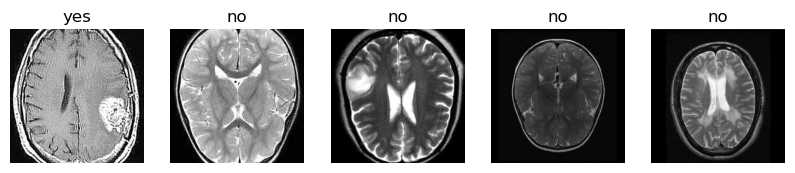

In [9]:
X_train, y_train = prepare_dataset(train_data)
X_val, y_val = prepare_dataset(val_data)
X_test, y_test = prepare_dataset(test_data)

show_sample_images(train_data, preprocess_image)


print(f"Total images excluded: {excluded_images_count}")
print(f"all images : {all_images}")

# Custom Model

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu, input_shape=(224, 224, 3)),  # Adjusted input shape
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu, name="final_conv_layer"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()
# Model Compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Training using Validation Data
history = model.fit(X_train, y_train, batch_size=16, epochs=5, verbose=1, validation_data=(X_val, y_val))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 final_conv_layer (Conv2D)   (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 100352)           

Text(0.5, 1.0, 'Loss over Epochs')

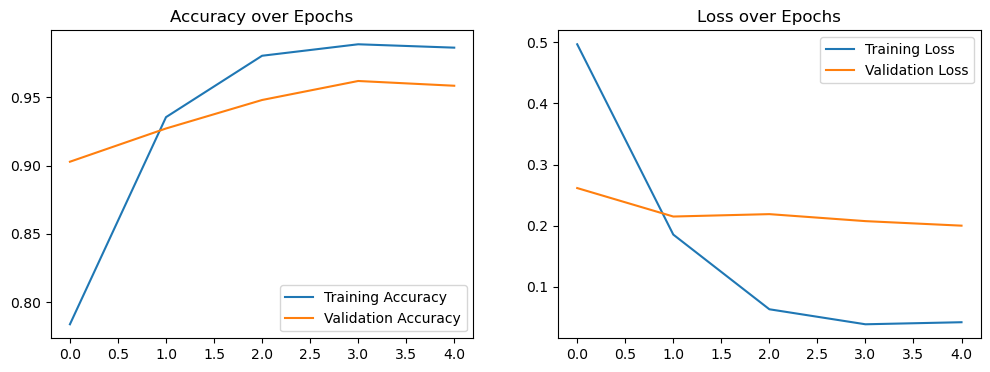

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

In [13]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    gradcam = Gradcam(model, model_modifier=None, clone=False)
    cam = gradcam(
        lambda output: output[pred_index] if pred_index else output,
        img_array,
        penultimate_layer=-1,
    )
    heatmap = normalize(cam)
    return heatmap

In [14]:
def show_images_with_heatmaps(image_paths, model, preprocess_func, last_conv_layer_name):
    plt.figure(figsize=(10, 10))

    for i, image_path in enumerate(image_paths):
        # Original image
        original_img = preprocess_func(image_path, (224, 224))
        ax = plt.subplot(5, 2, 2 * i + 1)
        plt.imshow(original_img)
        plt.title(f"Original - {image_path.split('/')[-1]}")
        plt.axis('off')

        img_array = np.array([original_img])
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        ax = plt.subplot(5, 2, 2 * i + 2)
        plt.imshow(original_img)
        plt.imshow(heatmap.squeeze(), cmap='jet', alpha=0.5)  
        plt.title("Heatmap")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

ValueError: Input 0 of layer "model_12" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(1, 224, 224, 3)

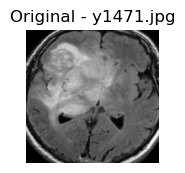

In [40]:
image_paths = [
    './data/yes/y1471.jpg',
    './data/yes/y1434.jpg',
    './data/yes/y624.jpg',
    './data/yes/y392.jpg',
    './data/no/no1094.jpg'
]

show_images_with_heatmaps(image_paths, model, preprocess_image, 'conv2d_4')

In [18]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

18/18 [==============================] - 3s 160ms/step - loss: 0.1056 - accuracy: 0.9688
Test Loss: 0.10559680312871933
Test Accuracy: 0.96875


# VGG16 Model

In [ ]:
# Load VGG16 pre-trained on ImageNet data
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze the base_model
base_model.trainable = False

# Add custom layers on top of VGG16 base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(X_train, y_train, batch_size=16, epochs=5, verbose=1, validation_data=(X_val, y_val))

# Use Grad-CAM
# show_images_with_heatmaps(image_paths, model, preprocess_image, 'block5_conv3')


# Classification Model

# Data Loading

In [37]:
def display_image(image_path):
    img = Image.open(image_path)
    img.show()

giloma_path = './data/classification_data/giloma'
meningioma_path = "./data/classification_data/meningioma"
pituitary_path = "./data/classification_data/pituitary"
no_tumor_path = "./data/classification_data/notumor"

In [38]:
def create_dataframe(giloma_path, meningioma_path, pituitary_path, no_tumor_path):
    # Initialize an empty list to store the data
    data = []

    # Process 'giloma' images
    for image in os.listdir(giloma_path):
        data.append({
            "image_path": os.path.join(giloma_path, image),
            "tumor_type": "giloma"
        })

    # Process 'meningioma' images
    for image in os.listdir(meningioma_path):
        data.append({
            "image_path": os.path.join(meningioma_path, image),
            "tumor_type": "meningioma"
        })
        
    # Process 'pituitary' images
    for image in os.listdir(pituitary_path):
        data.append({
            "image_path": os.path.join(pituitary_path, image),
            "tumor_type": "pituitary"
        })

    # Process 'no tumor' images
    for image in os.listdir(no_tumor_path):
        data.append({
            "image_path": os.path.join(no_tumor_path, image),
            "tumor_type": "no tumor"
        })

    # Create a DataFrame
    df = pd.DataFrame(data)

    return df

# Train, Test, Validation Splits

In [39]:
total_data = create_dataframe(giloma_path, meningioma_path, pituitary_path, no_tumor_path)
total_data = total_data.sample(frac=1).reset_index(drop=True)

In [40]:
# Shuffle and split the data
train_data, val_data, test_data = create_train_test_val_splits(total_data)

# Display the sizes of each set
print(f"Training Set: {len(train_data)}")
print(f"Validation Set: {len(val_data)}")
print(f"Test Set: {len(test_data)}")

print(train_data.head())

Training Set: 4915
Validation Set: 703
Test Set: 1405
                                             image_path tumor_type
5117  ./data/classification_data/pituitary/Tr-pi_141...  pituitary
2727  ./data/classification_data/notumor/Tr-no_1585.jpg   no tumor
6133   ./data/classification_data/giloma/Tr-gl_0936.jpg     giloma
908   ./data/classification_data/notumor/Te-no_0254.jpg   no tumor
953   ./data/classification_data/pituitary/Tr-pi_031...  pituitary


# Make images the same size and normalize

We use the preprocessing code provided by the dataset: 
https://github.com/masoudnick/Brain-Tumor-MRI-Classification/blob/main/Preprocessing.py

In [41]:
# Global counter for images that are excluded
excluded_images_count = 0
all_images = 0

# Using preprocessing code provided with the dataset
def preprocess_image(image_path, image_size=(256,256)):
    global excluded_images_count
    global all_images
    all_images += 1

    try:
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (3, 3), 0)
        
        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)
        
        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)
        
        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])
        ADD_PIXELS = 0
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.resize(new_img, image_size)
        return new_img
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        excluded_images_count += 1
        return None
    
def encode_label(label):
    if label == "giloma":
        return 1
    elif label == "meningioma":
        return 2
    elif label == "pituitary":
        return 3
    else:
        return 0
    
def prepare_dataset(df):
    images = df['image_path'].apply(lambda x: preprocess_image(x)).dropna()
    labels = df['tumor_type'][images.index].apply(encode_label)  # Align labels with images
    return np.array(images.tolist()), np.array(labels)

In [42]:
def show_sample_images(data, preprocess_func, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        img = preprocess_func(data.iloc[i]['image_path'])
        plt.imshow(img)
        plt.title(data.iloc[i]['tumor_type'])
        plt.axis("off")

Total images excluded: 0
all images : 7033


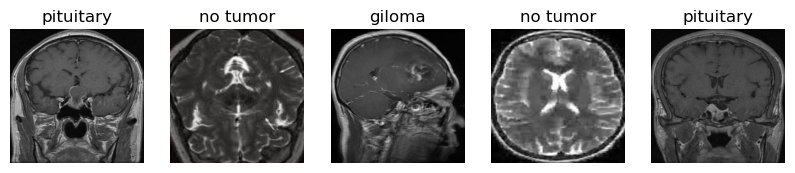

In [62]:
X_train, y_train = transform_dataset(train_data, target_size=(256, 256))
X_val, y_val = transform_dataset(val_data, target_size=(256, 256))
X_test, y_test = transform_dataset(test_data, target_size=(256, 256))

show_sample_images(train_data, preprocess_image)


print(f"Total images excluded: {excluded_images_count}")
print(f"all images : {all_images}")

# Custom Model

In [63]:
num_classes = 4
model_seg = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu, input_shape=(256, 256, 3)),  # Adjusted input shape
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Model Compilation
model_seg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model Training using Validation Data
history_seg = model_seg.fit(X_train, y_train, batch_size=16, epochs=5, verbose=1, validation_data=(X_val, y_val))

Epoch 1/5
308/308 [==============================] - 218s 701ms/step - loss: 1.4060 - accuracy: 0.7239 - val_loss: 0.4313 - val_accuracy: 0.8307
Epoch 2/5
308/308 [==============================] - 194s 629ms/step - loss: 0.4015 - accuracy: 0.8464 - val_loss: 0.3349 - val_accuracy: 0.8762
Epoch 3/5
308/308 [==============================] - 174s 566ms/step - loss: 0.2801 - accuracy: 0.8940 - val_loss: 0.3062 - val_accuracy: 0.8947
Epoch 4/5
308/308 [==============================] - 187s 609ms/step - loss: 0.1802 - accuracy: 0.9331 - val_loss: 0.2934 - val_accuracy: 0.8947
Epoch 5/5
308/308 [==============================] - 190s 618ms/step - loss: 0.1527 - accuracy: 0.9424 - val_loss: 0.2559 - val_accuracy: 0.9104


Text(0.5, 1.0, 'Loss over Epochs')

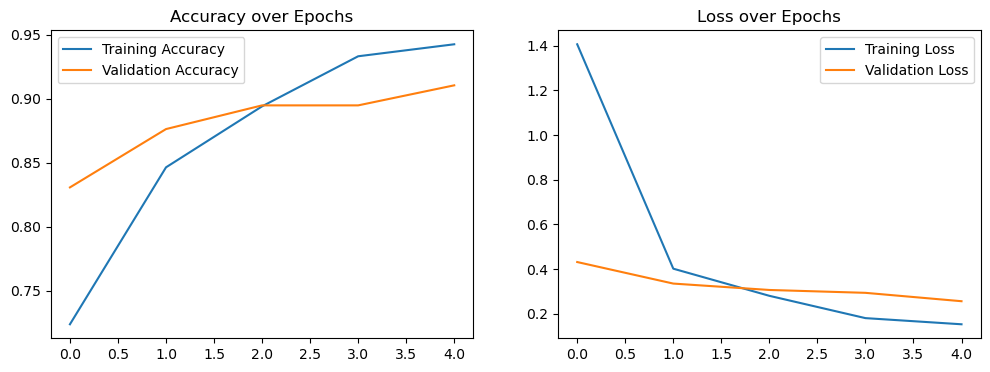

In [65]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_seg.history['accuracy'], label='Training Accuracy')
plt.plot(history_seg.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history_seg.history['loss'], label='Training Loss')
plt.plot(history_seg.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

In [66]:
test_loss, test_accuracy = model_seg.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

44/44 [==============================] - 13s 284ms/step - loss: 0.2510 - accuracy: 0.9196
Test Loss: 0.2509778141975403
Test Accuracy: 0.9195729494094849


### Confusion Matrix

In [76]:
test_predictions_seg = model_seg.predict(X_test)
test_predictions_classes_seg = np.argmax(test_predictions_seg, axis=1)

44/44 [==============================] - 12s 262ms/step


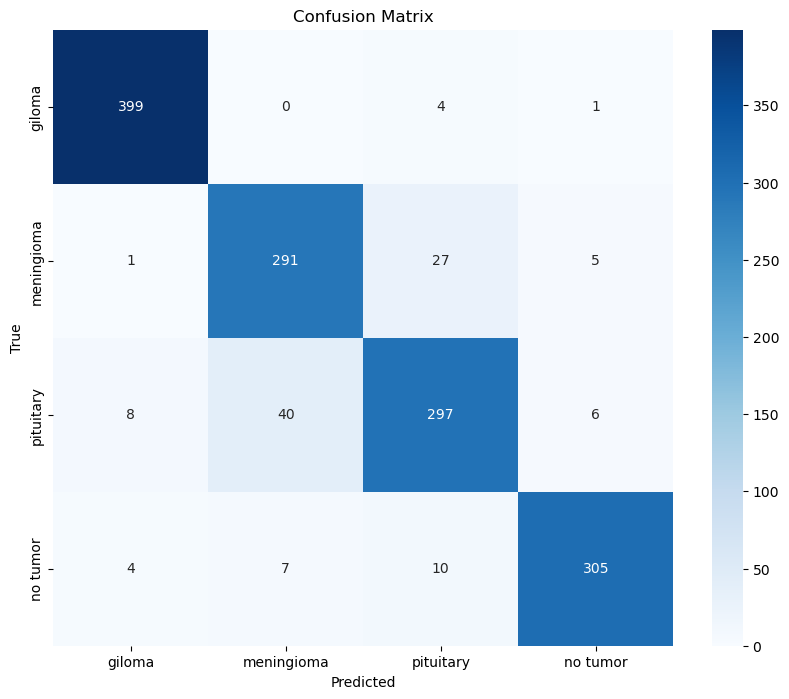

In [72]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, test_predictions_classes_seg)

# Define the labels of the tumor types
tumor_types = ['giloma', 'meningioma', 'pituitary', 'no tumor']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=tumor_types, yticklabels=tumor_types)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [75]:
report_seg = classification_report(y_test, test_predictions_classes_seg, target_names=tumor_types)
print(report_seg)

              precision    recall  f1-score   support

      giloma       0.97      0.99      0.98       404
  meningioma       0.86      0.90      0.88       324
   pituitary       0.88      0.85      0.86       351
    no tumor       0.96      0.94      0.95       326

    accuracy                           0.92      1405
   macro avg       0.92      0.92      0.92      1405
weighted avg       0.92      0.92      0.92      1405



## ResNet50 Model

### Train Model

In [19]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model.trainable = False

In [20]:
resnet_model = Sequential([
    resnet_model,  # This is the ResNet50 model instance
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # Example for binary classification
])

In [21]:
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
def preprocess_image_resnet50(image_path, target_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    return preprocess_input(img_array)

In [23]:
def encode_label(label):
    label_mapping = {'giloma': 0, 'meningioma': 1, 'pituitary': 2, 'no tumor': 3}
    return to_categorical(label_mapping[label], num_classes=4)

In [24]:
def transform_dataset(dataframe, target_size=(224, 224)):
    images = []
    labels = []

    for _, row in dataframe.iterrows():
        processed_img = preprocess_image_resnet50(row['image_path'], target_size)
        images.append(processed_img)
        label = encode_label(row['tumor_type'])
        labels.append(label)

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [25]:
train_images, train_labels = transform_dataset(train_data)
val_images, val_labels = transform_dataset(val_data)
test_images, test_labels = transform_dataset(test_data)

### Fit and Evaluate Model

In [26]:
# Train the model
history = resnet_model.fit(train_images, train_labels, epochs=5, validation_data=(val_images, val_labels))

# Evaluate the model
test_loss, test_acc = resnet_model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc*100:.2f}%")

Epoch 1/5
154/154 [==============================] - 360s 2s/step - loss: 2.4858 - accuracy: 0.6728 - val_loss: 0.4662 - val_accuracy: 0.8478
Epoch 2/5
154/154 [==============================] - 354s 2s/step - loss: 0.6146 - accuracy: 0.7422 - val_loss: 0.5112 - val_accuracy: 0.8321
Epoch 3/5
154/154 [==============================] - 355s 2s/step - loss: 0.5813 - accuracy: 0.7713 - val_loss: 0.4179 - val_accuracy: 0.8848
Epoch 4/5
154/154 [==============================] - 350s 2s/step - loss: 0.5547 - accuracy: 0.7890 - val_loss: 0.2738 - val_accuracy: 0.9047
Epoch 5/5
44/44 [==============================] - 83s 2s/step - loss: 0.3263 - accuracy: 0.8847
Test Accuracy: 88.47%


In [27]:
# Assuming test_images is your test set and resnet_model is your trained model
test_predictions = resnet_model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

44/44 [==============================] - 76s 2s/step


### Analyze Results

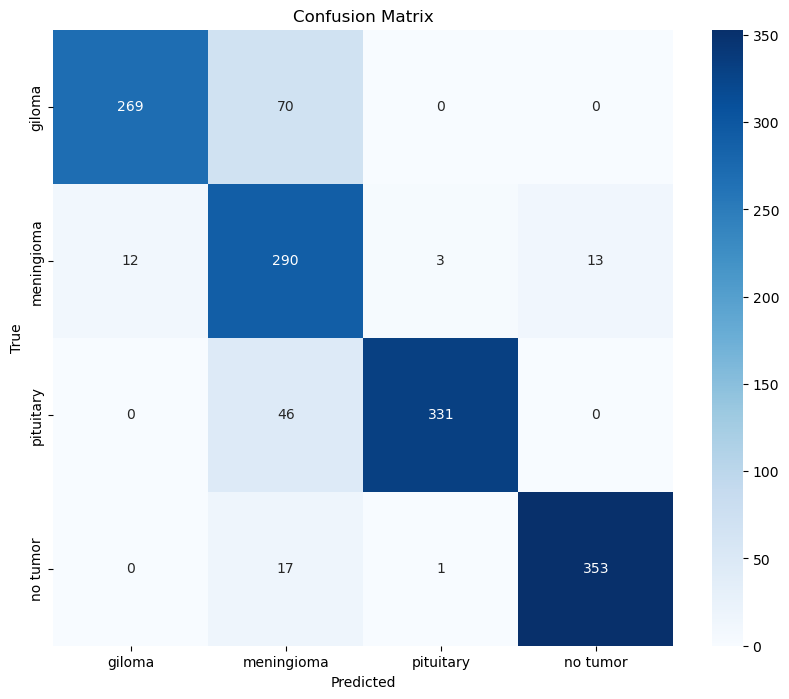

In [49]:
# Generate the confusion matrix
cm_res = confusion_matrix(test_true_classes, test_predictions_classes)

# Define the labels of the tumor types
tumor_types = ['giloma', 'meningioma', 'pituitary', 'no tumor']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_res, annot=True, fmt='g', cmap='Blues', xticklabels=tumor_types, yticklabels=tumor_types)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [73]:
report_resnet = classification_report(test_true_classes, test_predictions_classes, target_names=tumor_types)
print(report_resnet)

              precision    recall  f1-score   support

      giloma       0.96      0.79      0.87       339
  meningioma       0.69      0.91      0.78       318
   pituitary       0.99      0.88      0.93       377
    no tumor       0.96      0.95      0.96       371

    accuracy                           0.88      1405
   macro avg       0.90      0.88      0.88      1405
weighted avg       0.91      0.88      0.89      1405

